In [5]:
# imports
import pandas as pd
import optuna # pip install optuna
import matplotlib.pyplot as plt
import numpy as np

#froms
from prophet import Prophet
from sklearn.metrics import mean_absolute_error
from prophet.diagnostics import cross_validation, performance_metrics


In [9]:
# globales
df = pd.read_csv("../../data/dataset_training.csv", encoding="ISO-8859-1", low_memory=False)
dfPredicReal = pd.read_csv("../../data/dataset_prediction.csv", encoding="ISO-8859-1", low_memory=False)
print(f'\n DF limpio:')
print(df.info())
#scaling_factor = 1000 



 DF limpio:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 415310 entries, 0 to 415309
Data columns (total 15 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Unnamed: 0   415310 non-null  int64  
 1   InvoiceNo    415310 non-null  object 
 2   StockCode    415310 non-null  object 
 3   Description  415310 non-null  object 
 4   Quantity     415310 non-null  int64  
 5   InvoiceDate  415310 non-null  object 
 6   UnitPrice    415310 non-null  float64
 7   CustomerID   415310 non-null  float64
 8   Country      415310 non-null  object 
 9   TotalSales   415310 non-null  float64
 10  Year         415310 non-null  int64  
 11  Month        415310 non-null  int64  
 12  Day          415310 non-null  int64  
 13  DayOfWeek    415310 non-null  int64  
 14  Season       415310 non-null  object 
dtypes: float64(3), int64(6), object(6)
memory usage: 47.5+ MB
None


In [13]:
# paso a datetime por si acaso
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
# se necesitan dos columnas 'ds' e 'y', ds son las fechas, 'y' los valores que se quiere predecir
#dfPreparacion = df.set_index('InvoiceDate').resample('h')['Total'].sum().reset_index()

dfPreparacion= df.groupby(df['InvoiceDate'].dt.date)['TotalSales'].sum().reset_index()


# añadimos todos los domingos al df
dfPreparacion['InvoiceDate'] = pd.to_datetime(dfPreparacion['InvoiceDate'])
dfPreparacion = dfPreparacion.set_index('InvoiceDate').resample('D').sum().interpolate().reset_index()

dfPreparacion.columns = ['ds', 'y']
dfPreparacion['ds'] = pd.to_datetime(dfPreparacion['ds'])
#dfPreparacion['y'] = dfPreparacion['y'] * scaling_factor
print(f'\n DF de preparacion:')
print(dfPreparacion.info())
print(dfPreparacion.head())



 DF de preparacion:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 342 entries, 0 to 341
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      342 non-null    datetime64[ns]
 1   y       342 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 5.5 KB
None
          ds         y
0 2010-12-01  31033.52
1 2010-12-02  26214.02
2 2010-12-03  22908.14
3 2010-12-04      0.00
4 2010-12-05  22024.62


In [17]:
# para el calculo de mae
dfPredicReal['InvoiceDate'] = pd.to_datetime(dfPredicReal['InvoiceDate'])
yReal=dfPredicReal.groupby(dfPredicReal['InvoiceDate'].dt.date)['TotalSales'].sum().reset_index()
#yReal = dfPredicReal.set_index('InvoiceDate').resample('h')['Total'].sum().reset_index()
yReal['InvoiceDate'] = pd.to_datetime(yReal['InvoiceDate'])
#Añadimos fechas que faltan
yReal = yReal.set_index('InvoiceDate').resample('D').mean().fillna(0)
yReal = yReal.reset_index()

print(yReal.info())
print(yReal.head())

# dejamos solo el valor
yRealValues= yReal['TotalSales'].values
print(f"\n Sin fecha:")
print(yRealValues)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   InvoiceDate  32 non-null     datetime64[ns]
 1   TotalSales   32 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 644.0 bytes
None
  InvoiceDate  TotalSales
0  2011-11-08    56504.45
1  2011-11-09    62351.83
2  2011-11-10    68815.98
3  2011-11-11    54686.21
4  2011-11-12        0.00

 Sin fecha:
[ 56504.45  62351.83  68815.98  54686.21      0.    33341.65 111958.62
  60400.74  64123.06  60127.91  47886.8       0.    34352.65  48171.38
  62080.98  78223.52  47860.86  50310.39      0.    20239.79  55242.56
  72008.09  59049.59  51282.33  56898.47      0.    24421.82  57630.2
  54109.39  74952.61  81294.33  32111.91]


In [19]:
# Empezamos con el modelo
#model = Prophet(changepoint_prior_scale=0.01)
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    changepoint_prior_scale=0.0085,
    seasonality_mode="multiplicative")

model.add_country_holidays(country_name='UK')
model.add_seasonality(name="monthly", period=30.5, fourier_order=5)
#model.add_seasonality(name='weekly', period=24*6, fourier_order=5)  # Ciclo semanal


# Fit
model.fit(dfPreparacion)

# df con fechas futuras, 32 en este caso
future = model.make_future_dataframe(periods=32, freq ='D')
# Realizar predicciones
forecast = model.predict(future)
#forecast['yhat'] = forecast['yhat'] / scaling_factor

21:18:44 - cmdstanpy - INFO - Chain [1] start processing
21:18:44 - cmdstanpy - INFO - Chain [1] done processing


In [21]:
# Mostrar las predicciones , yhat predicion central, _lower y _upper intervalos de confianza
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(32))

            ds          yhat    yhat_lower    yhat_upper
342 2011-11-08  28503.097018  22958.574207  34305.500768
343 2011-11-09  26484.754954  20794.270573  32189.072593
344 2011-11-10  29149.837140  23550.983122  34803.065961
345 2011-11-11  23844.094797  18131.150783  29475.420226
346 2011-11-12   6834.628237   1070.486795  12314.527763
347 2011-11-13  15956.441394  10448.872482  21751.571532
348 2011-11-14  22600.891588  17002.088296  28613.791973
349 2011-11-15  24858.730619  19241.456963  30525.756296
350 2011-11-16  24394.355892  18858.204687  29639.404049
351 2011-11-17  28434.788735  22602.208910  34319.036886
352 2011-11-18  23924.350012  17998.140981  29302.471180
353 2011-11-19   7158.715529   1794.690101  12481.472058
354 2011-11-20  16201.869434  10663.708005  21986.028601
355 2011-11-21  22559.716338  17252.055552  28007.348418
356 2011-11-22  24284.450738  18513.739729  29872.625262
357 2011-11-23  23053.653218  17561.821624  28500.089519
358 2011-11-24  26355.258548  2

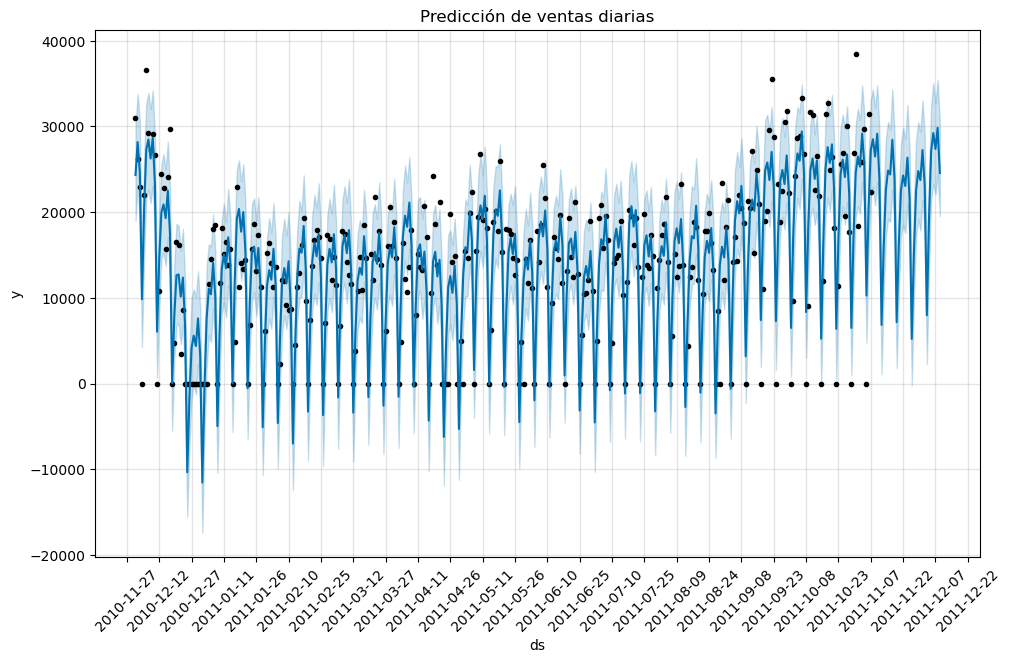

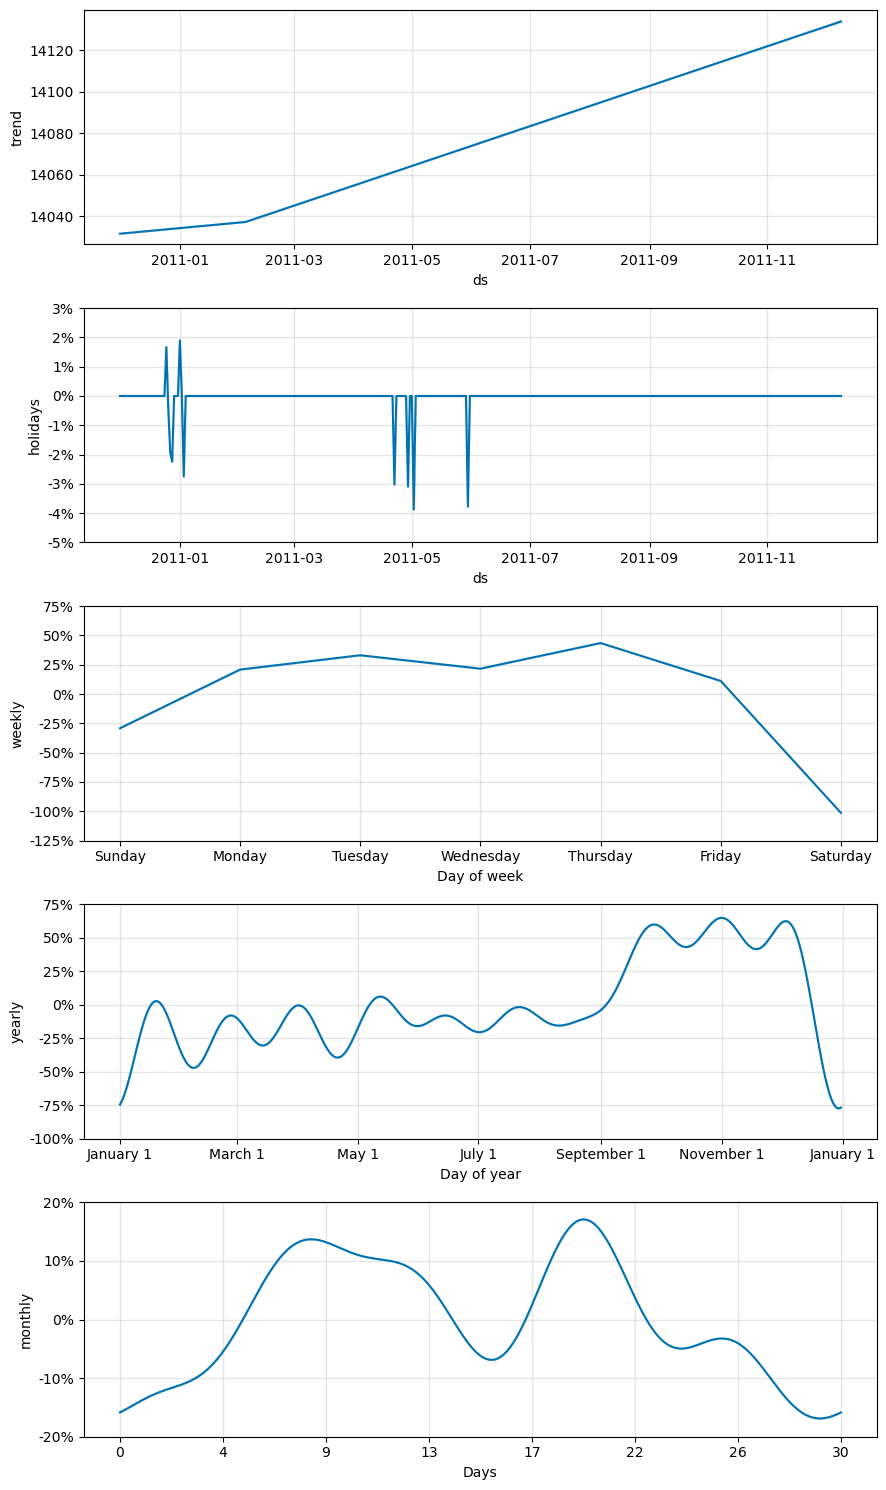

In [23]:
# Gráfico de predicción
fig = model.plot(forecast)
plt.xticks(rotation=45)  
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(31)) 

plt.title('Predicción de ventas diarias')
plt.show()


# Componentes del modelo
fig2 = model.plot_components(forecast)
plt.show()

In [25]:
yPred = forecast['yhat'].tail(32)
yPred = yPred.reset_index(drop=True)
yPred.head()
yPredValues= yPred.values

mae=mean_absolute_error(yRealValues, yPredValues)
print('MAE: %.3f' % mae)
relativeMae = (mae / dfPreparacion["y"].mean()) * 100
print(f"MAE relativo: {relativeMae:.2f}%")

MAE: 29109.776
MAE relativo: 211.81%


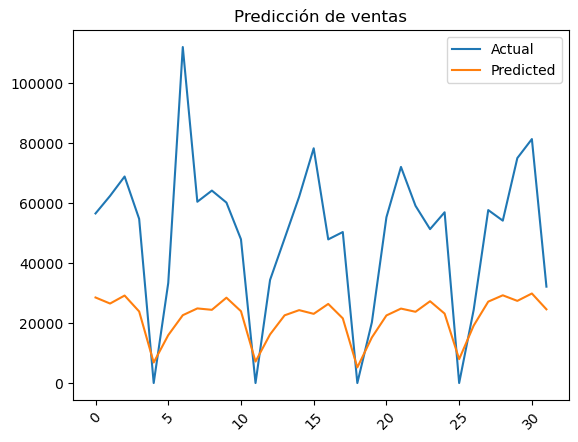

In [27]:
# plot expected vs actual
plt.plot(yRealValues, label='Actual')
plt.plot(yPredValues, label='Predicted')
plt.legend()
plt.xticks(rotation=45)  
plt.title('Predicción de ventas')
plt.show()

In [352]:
# Realizar validación cruzada
dfCv = cross_validation(model, initial='30 days', period='7 days', horizon='7 days');

# Calcular métricas de rendimiento
dfPerformance = performance_metrics(dfCv)
print(dfPerformance[['horizon', 'mae', 'rmse']])

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/44 [00:00<?, ?it/s]

18:25:21 - cmdstanpy - INFO - Chain [1] start processing
18:25:21 - cmdstanpy - INFO - Chain [1] done processing
18:25:21 - cmdstanpy - INFO - Chain [1] start processing
18:25:21 - cmdstanpy - INFO - Chain [1] done processing
18:25:21 - cmdstanpy - INFO - Chain [1] start processing
18:25:22 - cmdstanpy - INFO - Chain [1] done processing
18:25:22 - cmdstanpy - INFO - Chain [1] start processing
18:25:22 - cmdstanpy - INFO - Chain [1] done processing
18:25:22 - cmdstanpy - INFO - Chain [1] start processing
18:25:22 - cmdstanpy - INFO - Chain [1] done processing
18:25:22 - cmdstanpy - INFO - Chain [1] start processing
18:25:22 - cmdstanpy - INFO - Chain [1] done processing
18:25:22 - cmdstanpy - INFO - Chain [1] start processing
18:25:23 - cmdstanpy - INFO - Chain [1] done processing
18:25:23 - cmdstanpy - INFO - Chain [1] start processing
18:25:23 - cmdstanpy - INFO - Chain [1] done processing
18:25:23 - cmdstanpy - INFO - Chain [1] start processing
18:25:23 - cmdstanpy - INFO - Chain [1]

  horizon           mae          rmse
0  1 days  14243.954366  21083.032095
1  2 days   9631.106762  13008.258987
2  3 days  16463.797434  19758.204583
3  4 days  14924.360399  21664.794842
4  5 days  14037.040145  19644.322548
5  6 days  13794.127303  20058.645255
6  7 days  19105.885188  26516.974383
